In [1]:
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import sys
from itertools import combinations, product
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table, unique, join
import papermill as pm
from astropy.time import Time
corr = __import__('11_corr')


In [2]:
from uvot import filters
from xrt import curves
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [3]:
def line(x, m, c):
    return m*x+c

In [4]:
curve_energies = {'FULL' : '0.3 - 10.0',
                  'SOFT' : '0.3 - 1.5',
                  'HARD' : '1.5 - 10.0',
                  'HR'   : r'Ratio $\frac{(1.5 - 10.0)}{(0.3 - 1.5)}$'}

In [5]:
all_df = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_prop*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve   = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    
    df = pd.read_csv(f)
    df['simbad_name'] = simbad_name
    df['xrt_curve'] = xrt_curve
    df['uvot_filter'] = uvot_filter
    df['include_bad'] = include_bad
    df['include_UL']  = include_UL
    
    all_df.append(df)
df_prop = pd.concat(all_df)
df_prop


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:06<00:00, 166.54it/s]


,name,length,N_obs,N_bad,N_good,N_UL,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
0,tab,101,101,0,101,2,Holmberg_II_X-1,FULL,U,False,False
1,tab_5_sig,101,101,0,101,2,Holmberg_II_X-1,FULL,U,False,False
2,tab_UL,2,2,0,2,2,Holmberg_II_X-1,FULL,U,False,False
3,tab_no_UL,99,99,0,99,0,Holmberg_II_X-1,FULL,U,False,False
4,tab_BAD,0,0,0,0,0,Holmberg_II_X-1,FULL,U,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3,tab_no_UL,36,36,1,35,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
4,tab_BAD,1,1,1,0,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
5,tab_no_BAD,35,35,0,35,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False
6,tab_UL_no_bad,0,0,0,0,0,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,True,False


In [6]:
df_prop.sort_values('N_bad', ascending=False)

,name,length,N_obs,N_bad,N_good,N_UL,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
0,tab,390,390,371,19,376,M31_ULX-1,FULL,UVW1,True,True
0,tab,390,390,371,19,376,M31_ULX-1,FULL,UVW1,True,False
0,tab,390,390,371,19,376,M31_ULX-1,FULL,UVW1,False,False
0,tab,390,390,371,19,376,M31_ULX-1,FULL,UVW1,False,True
1,tab_5_sig,387,387,370,17,375,M31_ULX-1,FULL,UVW1,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2,tab_UL,0,0,0,0,0,NAME_NGC_925_ULX-2,HARD,UVW2,True,False
7,tab_no_UL_no_bad,17,17,0,17,0,NAME_NGC_925_ULX-2,HARD,UVW2,False,False
6,tab_UL_no_bad,0,0,0,0,0,NAME_NGC_925_ULX-2,HARD,UVW2,False,False
5,tab_no_BAD,17,17,0,17,0,NAME_NGC_925_ULX-2,HARD,UVW2,False,False


In [7]:
all_res = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_corr*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    
    # print(simbad_name, xrt_curve, uvot_filter)
    
    df = pd.read_csv(f)
    r_mean = df['r'].mean()
    r_std  = df['r'].std()
    m_mean = df['m'].mean()
    m_std  = df['m'].std()
    c_mean = df['c'].mean()
    c_std  = df['c'].std()
    
    res = {}
    res['simbad_name'] = simbad_name
    res['xrt_curve'] = xrt_curve
    res['uvot_filter'] = uvot_filter
    res['include_bad'] = include_bad
    res['include_UL'] = include_UL
    
    res['r_mean'] = r_mean
    res['r_std'] = r_std
    res['m_mean'] = m_mean
    res['m_std'] = m_std
    res['c_mean'] = c_mean
    res['c_std'] = c_std
    
    all_res.append(res)
df = pd.DataFrame(all_res)
df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:11<00:00, 89.02it/s]


,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
0,Holmberg_II_X-1,FULL,U,False,False,0.078401,0.038753,0.309246,0.152987,4.590543,0.025068
1,Holmberg_II_X-1,FULL,U,False,True,0.241506,0.049044,1.512485,0.540829,4.354644,0.104449
2,Holmberg_II_X-1,FULL,U,True,False,0.078649,0.038864,0.310456,0.153930,4.590257,0.025429
3,Holmberg_II_X-1,FULL,U,True,True,0.240904,0.048890,1.512175,0.541599,4.354559,0.104557
4,Holmberg_II_X-1,FULL,UVM2,False,False,-0.028678,0.078467,-0.116481,0.305358,2.070392,0.061065
...,...,...,...,...,...,...,...,...,...,...,...
1014,[SRW2006b]_NGC_55_ULX,SOFT,UVM2,True,False,0.153622,0.161702,0.492586,0.531787,0.280164,0.023336
1015,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,False,False,-0.005122,0.094803,-0.023778,0.523361,0.575838,0.025111
1016,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,True,False,-0.009399,0.093027,-0.046182,0.482841,0.577213,0.022766
1017,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,False,False,-0.144106,0.121953,-0.411822,0.356723,0.474929,0.016672


In [8]:
nsig     = 2
r_mu     = df['r_mean'].mean()
r_std    = df['r_mean'].std()
r_sig_up = r_mu + nsig*r_std
r_sig_lo = r_mu - nsig*r_std


#df['nsig'] = abs((df['r_mean'] - r_mu) / r_std)
df['nsig'] = df['r_mean'] / df['r_std']

In [9]:
df.sort_values('nsig')

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig
267,NAME_NGC_300_ULX1,SOFT,UVM2,True,False,-0.254680,0.011886,-4.260307,0.308411,0.517532,0.006058,-21.427433
266,NAME_NGC_300_ULX1,SOFT,UVM2,False,False,-0.254503,0.011982,-4.256458,0.309355,0.517381,0.006091,-21.239674
236,NAME_NGC_300_ULX1,FULL,UVM2,True,False,-0.305644,0.015128,-2.284671,0.157311,0.589273,0.009528,-20.203890
234,NAME_NGC_300_ULX1,FULL,UVM2,False,False,-0.305755,0.015286,-2.285559,0.158704,0.589368,0.009570,-20.002840
242,NAME_NGC_300_ULX1,FULL,UVW2,False,False,-0.321478,0.016286,-3.276323,0.227465,0.901332,0.013704,-19.739294
...,...,...,...,...,...,...,...,...,...,...,...,...
423,NOVA_Cyg_1989,FULL,B,True,False,0.558393,0.005926,0.111932,0.000960,12.626329,0.163739,94.222575
447,NOVA_Cyg_1989,HARD,U,False,False,0.607064,0.005621,0.094074,0.002479,10.048803,0.094176,107.998942
448,NOVA_Cyg_1989,HARD,U,True,False,0.611792,0.005609,0.095537,0.002536,9.131601,0.088358,109.069842
425,NOVA_Cyg_1989,FULL,U,False,False,0.634599,0.003570,0.069448,0.000621,8.838532,0.039035,177.737463


In [10]:
source_names_dict

{'ESO_243-49_HLX-1': 'ESO243-49',
 'NAME_Holmberg_IX_X-1': 'Holmberg_IX',
 'Holmberg_II_X-1': 'Holmberg_II',
 'M31_ULX-1': 'M31',
 '[LM2005]_NGC_598_ULX1': 'M33',
 'RX_J133001+47137': 'M51',
 '[LM2005]_NGC_3031_ULX1': 'M81',
 'M82_X-2': 'M82',
 '[LM2005]_NGC_1042_ULX1': 'NGC1042',
 'NAME_NGC_1313_X-1': 'NGC1313',
 'NAME_NGC_1313_X-2': 'NGC1313',
 '[LM2005]_NGC_247_ULX1': 'NGC247',
 '[LB2005]_NGC_253_X2': 'NGC253',
 '[LB2005]_NGC_253_X9': 'NGC253',
 'NAME_NGC_300_ULX1': 'NGC300',
 '[LM2005]_NGC_4395_ULX1': 'NGC4395',
 '[LM2005]_NGC_5204_ULX1': 'NGC5204',
 '[LM2005]_NGC_5408_ULX1': 'NGC5408',
 '[SRW2006b]_NGC_55_ULX': 'NGC55',
 '[SST2011]_J141939.39+564137.8': 'NGC5585',
 'NAME_NGC_5907_ULX': 'NGC5907',
 '[LB2005]_NGC_6946_ULX1': 'NGC6946',
 '[LB2005]_NGC_6946_ULX3': 'NGC6946',
 'NAME_NGC_7090_ULX3': 'NGC7090',
 'NAME_NGC_7793_P13': 'NGC7793',
 'NAME_NGC_925_ULX-1': 'NGC925',
 'NAME_NGC_925_ULX-2': 'NGC925',
 'SMC_X-3': 'SMC_X-3',
 'SS433': 'SS433',
 'SWIFT_J0243.6+6124': 'Swift_J0243.6+

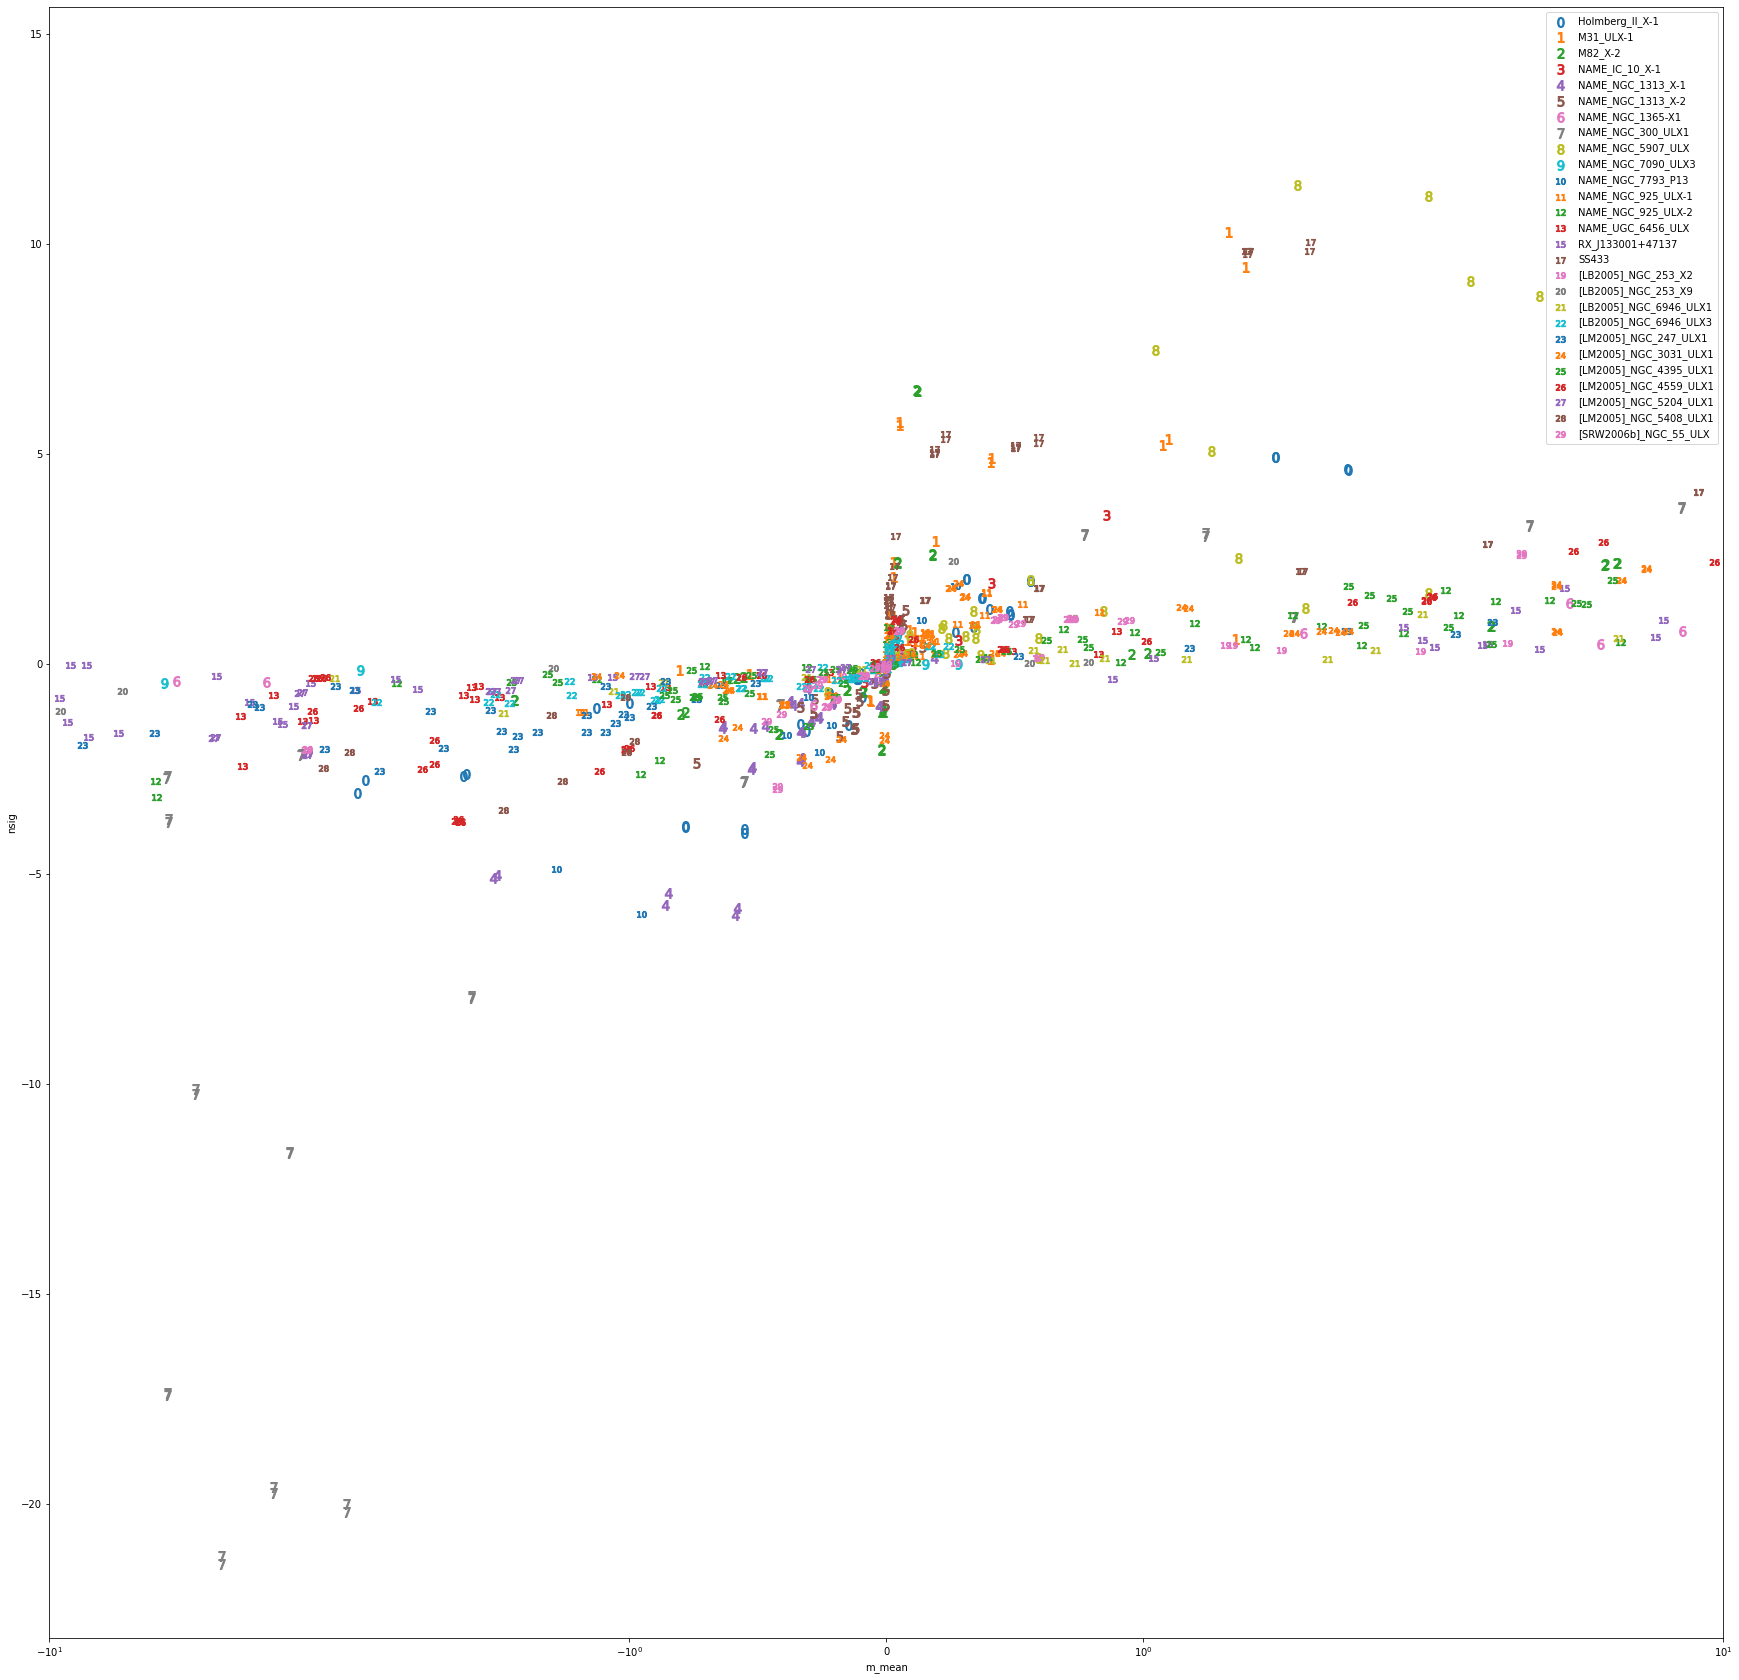

In [11]:
exclude = ['SWIFT_J0243.6+6124', 'NOVA_Cyg_1989', 'SMC_X-3']
plt.figure(figsize=(30,30), facecolor='white')
for i, s in enumerate(df['simbad_name'].unique()):
    if s in exclude:
        continue
    sub = df[df['simbad_name'] == s]
    plt.scatter(sub['m_mean'], sub['nsig'], marker=f'${i}$', label=s, s=100)
    #plt.errorbar(sub['m_mean'], sub['r_mean'], xerr=sub['m_std'], yerr=sub['r_std'], marker=f'${i}$', label=s, markersize=10)
plt.xlabel('m_mean')
plt.ylabel('nsig')

plt.xscale('symlog')
#plt.ylim(-5,5)
plt.xlim(-10,10)
plt.legend()
#plt.ylim(-10,10)

In [12]:
#sub_nsig = df[(df['r_mean'] > r_sig_up) | (df['r_mean'] < r_sig_lo)]
sub_nsig = df[df['nsig'] > 3]

In [13]:
df_prop_tab_3_sig = df_prop[df_prop['name'] == 'tab_3_sig']

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
df_3_sig_merge = pd.merge(sub_nsig, df_prop_tab_3_sig, on=['simbad_name','xrt_curve','uvot_filter','include_bad','include_UL'])
df_3_sig_merge

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig,name,length,N_obs,N_bad,N_good,N_UL


In [16]:
df[df['simbad_name'] == 'NAME_NGC_7793_P13']

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,nsig
315,NAME_NGC_7793_P13,FULL,U,False,False,-0.095743,0.065639,-0.216724,0.150289,0.215136,0.011059,-1.458630
316,NAME_NGC_7793_P13,FULL,U,False,True,0.123077,0.066133,0.269201,0.145042,0.174397,0.010567,1.861049
317,NAME_NGC_7793_P13,FULL,U,True,False,-0.122051,0.058343,-0.263424,0.127846,0.219438,0.008783,-2.091956
318,NAME_NGC_7793_P13,FULL,U,True,True,0.060968,0.058117,0.135804,0.129628,0.186543,0.008921,1.049050
319,NAME_NGC_7793_P13,HARD,U,False,False,-0.111143,0.065478,-0.391508,0.234342,0.216675,0.010689,-1.697408
320,NAME_NGC_7793_P13,HARD,U,True,False,-0.262267,0.043996,-0.954550,0.170350,0.245856,0.006704,-5.961201
321,NAME_NGC_7793_P13,SOFT,U,False,False,-0.057687,0.072415,-0.306109,0.382504,0.208740,0.010925,-0.796616
322,NAME_NGC_7793_P13,SOFT,U,True,False,-0.231226,0.047363,-1.285210,0.280488,0.241723,0.006758,-4.882024
